# Creating University Program Curriculumn based on Clustering of Skills in Job Postings  (Assignment 3 template)

In [467]:
import numpy as np
import pandas as pd
import openai
from openai import OpenAI
from numpy import zeros as sci_zeros
import os
import re
import requests
from wordcloud import WordCloud
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

In [619]:
## Machine Learning libraries
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import ClusterWarning
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

## Data processing, feature engineering

### Engineer features for clustering analysis and visualization

#### Using LLM to generate skills

In [6]:
system_prompt = "You are a hiring manager at a top tech company. You are looking for a candidate who is an extroadinary data scientist and artificial intelligence engineer."

In [ ]:
client = OpenAI(api_key="your-api-key-here", base_url="https://api.deepseek.com")

In [ ]:
# Technical skills
prompt1 = "Please tell me the technical skills that you think are important for a career as a data scientist/analytics and data manager/data analyst/business analyst/AI system designer/AI engineer, etc. Please give me a python dictionary with the category as the key and the skills as the value. The skills should be in a list. No explaination is needed. Limit the category up to 5. There should be at least 10 skills in each category. Just the dictionary."

response1 = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt1},
    ],
    temperature=1.3,
    stream=False
)

print(response1.choices[0].message.content)

```python
{
    "Programming": ["Python", "R", "SQL", "Java", "Scala", "C++", "Julia", "MATLAB", "Bash", "JavaScript"],
    "Data Manipulation": ["Pandas", "NumPy", "dplyr", "SQLAlchemy", "Apache Spark", "Hadoop", "Apache Kafka", "Polars", "Dask", "PySpark"],
    "Machine Learning": ["Scikit-learn", "TensorFlow", "PyTorch", "Keras", "XGBoost", "LightGBM", "CatBoost", "H2O", "MLlib", "FastAI"],
    "Data Visualization": ["Matplotlib", "Seaborn", "Plotly", "ggplot2", "Tableau", "Power BI", "D3.js", "Bokeh", "Altair", "Plotnine"],
    "AI/Deep Learning": ["Neural Networks", "Natural Language Processing", "Computer Vision", "Reinforcement Learning", "Generative Adversarial Networks", "Transformers", "AutoML", "OpenAI GPT", "BERT", "YOLO"]
}
```


In [21]:
# Business skills and soft skills
prompt2 = "Please tell me the business skills and soft skills that you think are important for a career as a data scientist/analytics and data manager/data analyst/business analyst/AI system designer/AI engineer, etc. Please give me a python list of the skills. Limit the skills up to 10. No explaination is needed."

response2 = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt2},
    ],
    temperature=1.3,
    stream=False
)

print(response2.choices[0].message.content)

```python
skills = [
    "Problem-Solving",
    "Communication",
    "Team Collaboration",
    "Critical Thinking",
    "Business Acumen",
    "Data Visualization",
    "Project Management",
    "Adaptability",
    "Leadership",
    "Attention to Detail"
]
```


#### Create the skills dictionary combined with the LLM response and my own knowledge

In [534]:
# Programming/systems skills
sskills = {}
sskills['Python'] = []
sskills['Matlab'] = []
sskills['C/C++'] = []
sskills['Java'] = []
sskills['JavaScript'] = []
sskills['R'] = []
sskills['SQL'] = []
sskills['VBA'] = []

# Data manipulation skills
dmskills = {}
dmskills['Pandas'] = []
dmskills['NumPy'] = []
dmskills['SciPy'] = []
dmskills['Big Data'] = []
dmskills['Data Mining'] = []
dmskills['Data Wrangling'] = []
dmskills['Data Cleaning'] = []
dmskills['Database'] = []
dmskills['Data Analysis'] = []
dmskills['Hadoop'] = []
dmskills['Spark'] = []
dmskills['Excel'] = []
dmskills['ETL'] = []

# Machine Learning skills
mlskills = {}
mlskills['Supervised Learning'] = []
mlskills['Unsupervised Learning'] = []
mlskills['Reinforcement Learning'] = []
mlskills['Scikit-learn'] = []
mlskills['TensorFlow'] = []
mlskills['Keras'] = []
mlskills['PyTorch'] = []
mlskills['XGBoost'] = []
mlskills['Predictive Modeling'] = []
mlskills['Feature Engineering'] = []
mlskills['Model Evaluation'] = []
mlskills['Model Validation'] = []

# Data visualization skills
dvskills = {}
dvskills['Tableau'] = []
dvskills['Power BI'] = []
dvskills['Matplotlib'] = []
dvskills['Seaborn'] = []
dvskills['ggplot'] = []

# AI/Deep Learning skills
aiskills = {}
aiskills['Deep Learning'] = []
aiskills['Neural Networks'] = []
aiskills['Natural Language Processing'] = []
aiskills['Transformers'] = []
aiskills['CNN'] = []
aiskills['RNN'] = []
aiskills['LSTM'] = []

# Business skills and soft skills
bskills = {}
bskills['Business Acumen'] = []
bskills['Communication'] = []
bskills['Problem Solving'] = []
bskills['Critical Thinking'] = []
bskills['Collaboration'] = []
bskills['Leadership'] = []
bskills['Time Management'] = []
bskills['Creativity'] = []
bskills['Adaptability'] = []
bskills['Presentation'] = []
bskills['Negotiation'] = []
bskills['Decision Making'] = []

### Data Processing

#### Load job postings web-scraped from Indeed.com

In [535]:
## Sample dataset file name (replace this sample dataset with the dataset to be used in Assignment 3)
filename_data = 'Data_Scientist_Canada_US_Remote.csv'

## Read csv file (dataset)
results = pd.read_csv(filename_data)

#Change column names
results.rename(columns={'Job_Title': 'Title', 'Company_Name': 'Company', 'Job_Description': 'Descriptions'}, inplace=True)

In [536]:
# checking missing values in the dataset
results.isnull().sum()

Title               2
Company             5
Location            4
Rating          13264
Date             2689
Salary          10093
Links            1611
Descriptions        4
Combined            5
dtype: int64

In [537]:
# remove rows with missing values in the 'Descriptions' column
results = results.dropna(subset=['Descriptions'])

In [538]:
results.head(5)

,Title,Company,Location,Rating,Date,Salary,Links,Descriptions,Combined
0,Data Scientist [Post-Doc Research Fellow],Edison Welding Institute Inc,"Buffalo, NY 14211Â (Grider area)",NaN,EmployerActive 8 days ago,"$75,000 - $90,000 a year",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Buffalo Manufacturing Works, operated by EWI, ...",Data Scientist [Post-Doc Research Fellow] Buff...
1,Data Scientist,CVS Health,"New York, NY",NaN,PostedPosted 6 days ago,"$80,500 - $170,000 a year",https://www.indeed.com/rc/clk?jk=4b029f55b2180...,Bring your heart to CVS Health. Every one of u...,Data Scientist Bring your heart to CVS Health....
2,Data Scientist,NYC Health + Hospitals,"Remote in New York, NY",NaN,PostedPosted 14 days ago,NaN,https://www.indeed.com/rc/clk?jk=39620c4b48632...,About NYC Health + Hospitals\n\nMetroPlusHealt...,Data Scientist About NYC Health + Hospitals\n\...
3,Data Scientist,Saks,"New York, NY 10281Â (Battery Park area)",NaN,PostedPosted 6 days ago,"$135,782 - $140,000 a year",https://www.indeed.com/rc/clk?jk=0f5809218e9f9...,Job Details\n\nJob Description:\nWho We Are:\n...,Data Scientist Job Details\n\nJob Description:...
4,Data Scientist - Consumer Analytics,CVS Health,"New York, NY",NaN,PostedPosted 17 days ago,"$80,500 - $170,000 a year",https://www.indeed.com/rc/clk?jk=6754b40ffbc6c...,Bring your heart to CVS Health. Every one of u...,Data Scientist - Consumer Analytics Bring your...


#### Extract skills from job postings

In [540]:
## Extract skills from job postings
for ir, dfr in results.iterrows():
    cleantext = str(dfr["Descriptions"])
    cleantext = cleantext.lower()
    
    # Extract programming/systems skills
    sskills['Python'].append('1' if "python" in cleantext else '0')
    sskills['Matlab'].append('1' if "matlab" in cleantext else '0')
    sskills['C/C++'].append('1' if ("c++" in cleantext) or (" c " in cleantext) or (" c," in cleantext) or (" c." in cleantext) else '0')
    sskills['Java'].append('1' if "java" in cleantext else '0')
    sskills['JavaScript'].append('1' if "javascript" in cleantext else '0')
    sskills['R'].append('1' if (" r " in cleantext) or (" r," in cleantext) or (" r." in cleantext) else '0')
    sskills['SQL'].append('1' if "sql" in cleantext else '0')
    sskills['VBA'].append('1' if "vba" in cleantext else '0')

    # Extract data manipulation skills
    dmskills['Pandas'].append('1' if "pandas" in cleantext else '0')
    dmskills['NumPy'].append('1' if "numpy" in cleantext else '0')
    dmskills['SciPy'].append('1' if "scipy" in cleantext else '0')
    dmskills['Big Data'].append('1' if "big data" in cleantext else '0')
    dmskills['Data Mining'].append('1' if "data mining" in cleantext else '0')
    dmskills['Data Wrangling'].append('1' if "data wrangling" in cleantext else '0')
    dmskills['Data Cleaning'].append('1' if "data cleaning" in cleantext else '0')
    dmskills['Database'].append('1' if "database" in cleantext else '0')
    dmskills['Data Analysis'].append('1' if ("data analysis" in cleantext) or ("data analytics" in cleantext) else '0')
    dmskills['Hadoop'].append('1' if "hadoop" in cleantext else '0')
    dmskills['Spark'].append('1' if "spark" in cleantext else '0')
    dmskills['Excel'].append('1' if "excel" in cleantext else '0')
    dmskills['ETL'].append('1' if "etl" in cleantext else '0')

    # Extract machine learning skills
    mlskills['Supervised Learning'].append('1' if "supervised learning" in cleantext else '0')
    mlskills['Unsupervised Learning'].append('1' if "unsupervised learning" in cleantext else '0')
    mlskills['Reinforcement Learning'].append('1' if "reinforcement learning" in cleantext else '0')
    mlskills['Scikit-learn'].append('1' if ("scikit-learn" in cleantext) or ("scikit learn" in cleantext) else '0')
    mlskills['TensorFlow'].append('1' if "tensorflow" in cleantext else '0')
    mlskills['Keras'].append('1' if "keras" in cleantext else '0')
    mlskills['PyTorch'].append('1' if "pytorch" in cleantext else '0')
    mlskills['XGBoost'].append('1' if "xgboost" in cleantext else '0')
    mlskills['Predictive Modeling'].append('1' if "predictive modeling" in cleantext else '0')
    mlskills['Feature Engineering'].append('1' if "feature engineering" in cleantext else '0')
    mlskills['Model Evaluation'].append('1' if "model evaluation" in cleantext else '0')
    mlskills['Model Validation'].append('1' if "model validation" in cleantext else '0')

    # Extract data visualization skills
    dvskills['Tableau'].append('1' if "tableau" in cleantext else '0')
    dvskills['Power BI'].append('1' if "power bi" in cleantext else '0')
    dvskills['Matplotlib'].append('1' if "matplotlib" in cleantext else '0')
    dvskills['Seaborn'].append('1' if "seaborn" in cleantext else '0')
    dvskills['ggplot'].append('1' if "ggplot" in cleantext else '0')

    # Extract AI/Deep Learning skills
    aiskills['Deep Learning'].append('1' if "deep learning" in cleantext else '0')
    aiskills['Neural Networks'].append('1' if "neural networks" in cleantext else '0')
    aiskills['Natural Language Processing'].append('1' if ("natural language processing" in cleantext) or ("nlp" in cleantext) else '0')
    aiskills['Transformers'].append('1' if "transformer" in cleantext else '0')
    aiskills['CNN'].append('1' if ("cnn" in cleantext or "convolutional neural network" in cleantext) else '0')
    aiskills['RNN'].append('1' if ("rnn" in cleantext or "recurrent neural network" in cleantext) else '0')
    aiskills['LSTM'].append('1' if ("lstm" in cleantext or "long short term memory" in cleantext) else '0')

    # Extract business skills and soft skills
    bskills['Business Acumen'].append('1' if ("business acumen" in cleantext or "business sense" in cleantext) else '0')
    bskills['Communication'].append('1' if ("communication" in cleantext or "communicate" in cleantext) else '0')
    bskills['Problem Solving'].append('1' if ("problem solving" in cleantext or "problem-solver" in cleantext) else '0')
    bskills['Critical Thinking'].append('1' if ("critical thinking" in cleantext or "critical-thinker" in cleantext) else '0')
    bskills['Collaboration'].append('1' if ("collaboration" in cleantext or "collaborate" in cleantext) else '0')
    bskills['Leadership'].append('1' if ("leadership" in cleantext or "leader" in cleantext or "lead" in cleantext) else '0')
    bskills['Time Management'].append('1' if ("time management" in cleantext or "time-management" in cleantext) else '0')
    bskills['Creativity'].append('1' if ("creativity" in cleantext or "creative" in cleantext or "create" in cleantext) else '0')
    bskills['Adaptability'].append('1' if ("adaptability" in cleantext or "adaptable" in cleantext) else '0')
    bskills['Presentation'].append('1' if ("presentation" in cleantext or "present" in cleantext) else '0')
    bskills['Negotiation'].append('1' if ("negotiation" in cleantext or "negotiate" in cleantext) else '0')
    bskills['Decision Making'].append('1' if ("decision making" in cleantext or "decision-maker" in cleantext or "make decision" in cleantext) else '0')

In [541]:
## Create dataframe with extracted skills (1 if a skill was found in job description, 0 if a skills was not found in job description)
df1 = results[['Title', 'Company', 'Location', 'Descriptions']].copy()
df2 = pd.DataFrame(sskills)
df3 = pd.DataFrame(dmskills)
df4 = pd.DataFrame(mlskills)
df5 = pd.DataFrame(dvskills)
df6 = pd.DataFrame(aiskills)
df7 = pd.DataFrame(bskills)

In [542]:
# Concatenate all dataframes
df = pd.concat([df1, df2, df3, df4, df5, df6, df7], axis=1)
df.head(5)

,Title,Company,Location,Descriptions,Python,Matlab,C/C++,Java,JavaScript,R,...,Problem Solving,Critical Thinking,Collaboration,Leadership,Time Management,Creativity,Adaptability,Presentation,Negotiation,Decision Making
0,Data Scientist [Post-Doc Research Fellow],Edison Welding Institute Inc,"Buffalo, NY 14211Â (Grider area)","Buffalo Manufacturing Works, operated by EWI, ...",1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1,Data Scientist,CVS Health,"New York, NY",Bring your heart to CVS Health. Every one of u...,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,Data Scientist,NYC Health + Hospitals,"Remote in New York, NY",About NYC Health + Hospitals\n\nMetroPlusHealt...,1,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
3,Data Scientist,Saks,"New York, NY 10281Â (Battery Park area)",Job Details\n\nJob Description:\nWho We Are:\n...,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
4,Data Scientist - Consumer Analytics,CVS Health,"New York, NY",Bring your heart to CVS Health. Every one of u...,1,0,0,0,0,1,...,0,0,1,1,0,0,0,1,0,0


In [543]:
## Save skills as 2D array
df_skills = df.iloc[:, 4:]
df_skills = df_skills.apply(pd.to_numeric)
a = df_skills.values

# make sure all value in the array are int (0, 1)
a = a.astype(int)

print("Number of job postings:", a.shape[0])
print(a)

Number of job postings: 16796
[[1 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]


C:\Users\82519\AppData\Local\Temp\ipykernel_43304\1130221481.py:7: RuntimeWarning: invalid value encountered in cast
  a = a.astype(int)


In [544]:
df_skills.shape

(16796, 57)

In [545]:
df_skills.columns.to_list()

['Python',
 'Matlab',
 'C/C++',
 'Java',
 'JavaScript',
 'R',
 'SQL',
 'VBA',
 'Pandas',
 'NumPy',
 'SciPy',
 'Big Data',
 'Data Mining',
 'Data Wrangling',
 'Data Cleaning',
 'Database',
 'Data Analysis',
 'Hadoop',
 'Spark',
 'Excel',
 'ETL',
 'Supervised Learning',
 'Unsupervised Learning',
 'Reinforcement Learning',
 'Scikit-learn',
 'TensorFlow',
 'Keras',
 'PyTorch',
 'XGBoost',
 'Predictive Modeling',
 'Feature Engineering',
 'Model Evaluation',
 'Model Validation',
 'Tableau',
 'Power BI',
 'Matplotlib',
 'Seaborn',
 'ggplot',
 'Deep Learning',
 'Neural Networks',
 'Natural Language Processing',
 'Transformers',
 'CNN',
 'RNN',
 'LSTM',
 'Business Acumen',
 'Communication',
 'Problem Solving',
 'Critical Thinking',
 'Collaboration',
 'Leadership',
 'Time Management',
 'Creativity',
 'Adaptability',
 'Presentation',
 'Negotiation',
 'Decision Making']

### Visualize key information

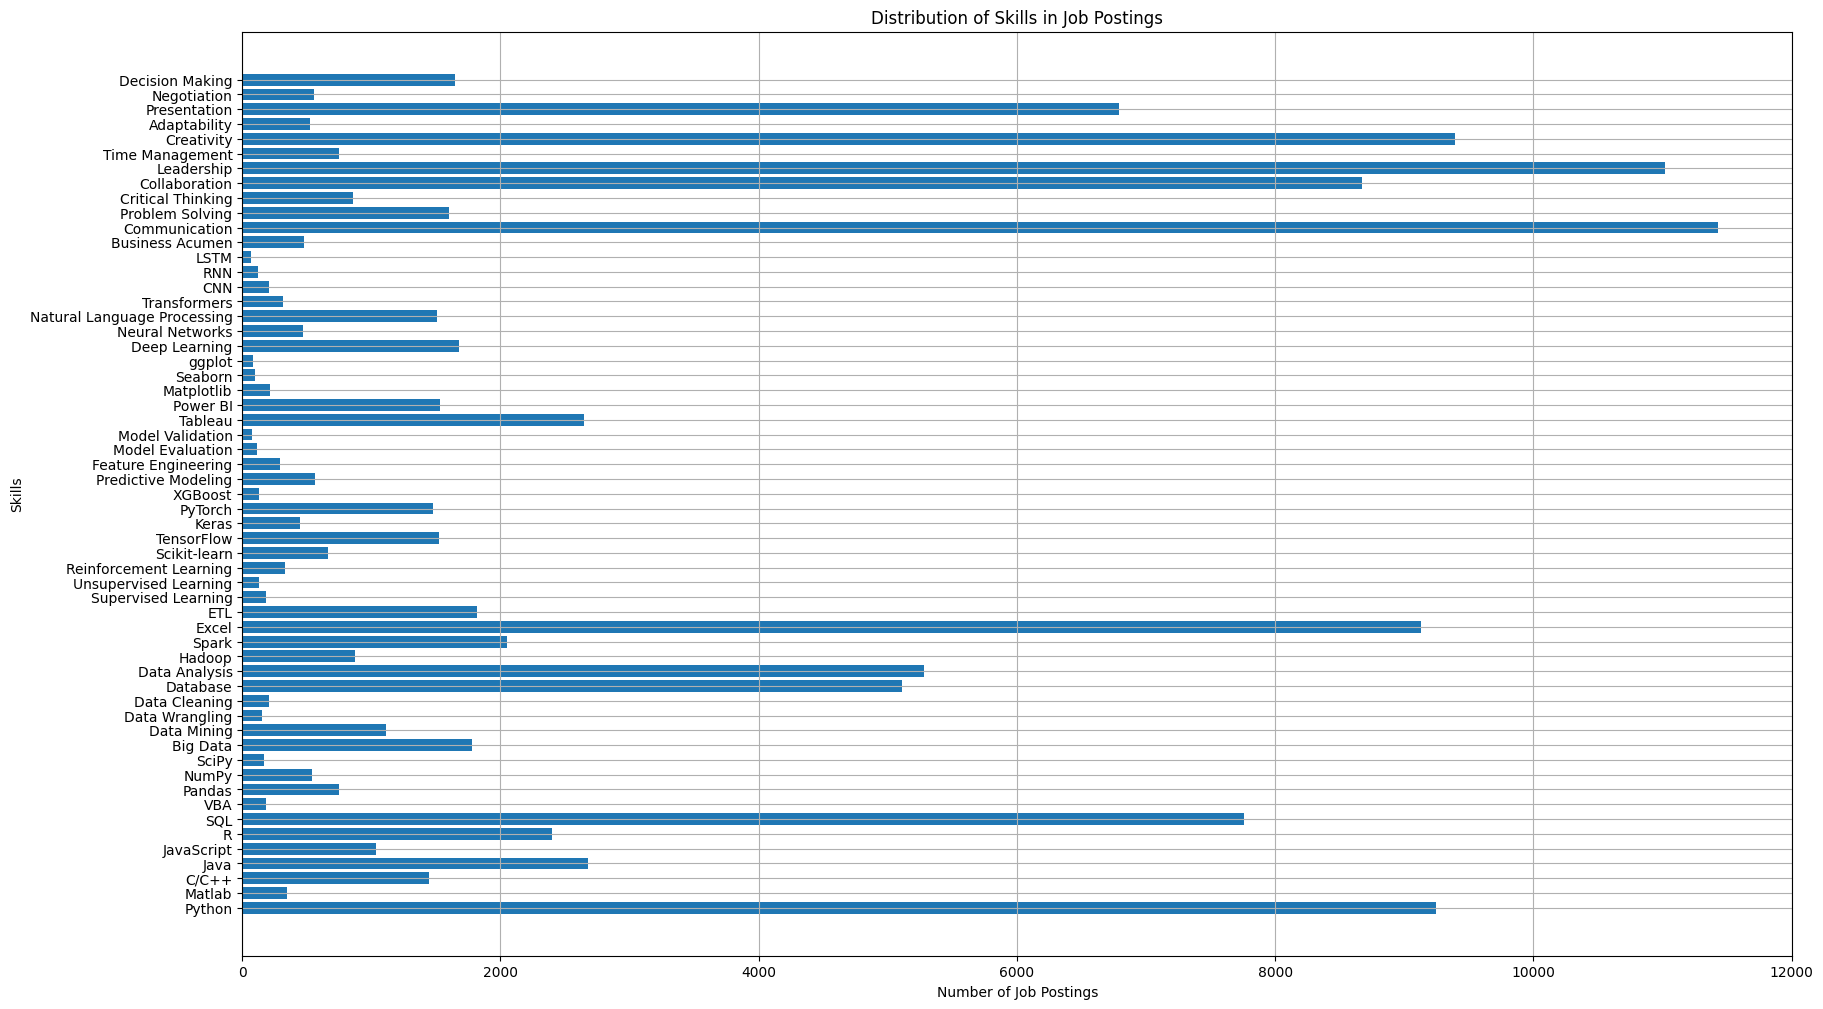

In [546]:
# Plot the distribution of skills in the dataset
plt.figure(figsize=(20, 12))
plt.barh(df_skills.columns, df_skills.sum(axis=0))
plt.xlabel('Number of Job Postings')
plt.ylabel('Skills')
plt.title('Distribution of Skills in Job Postings')
plt.grid()
plt.show()

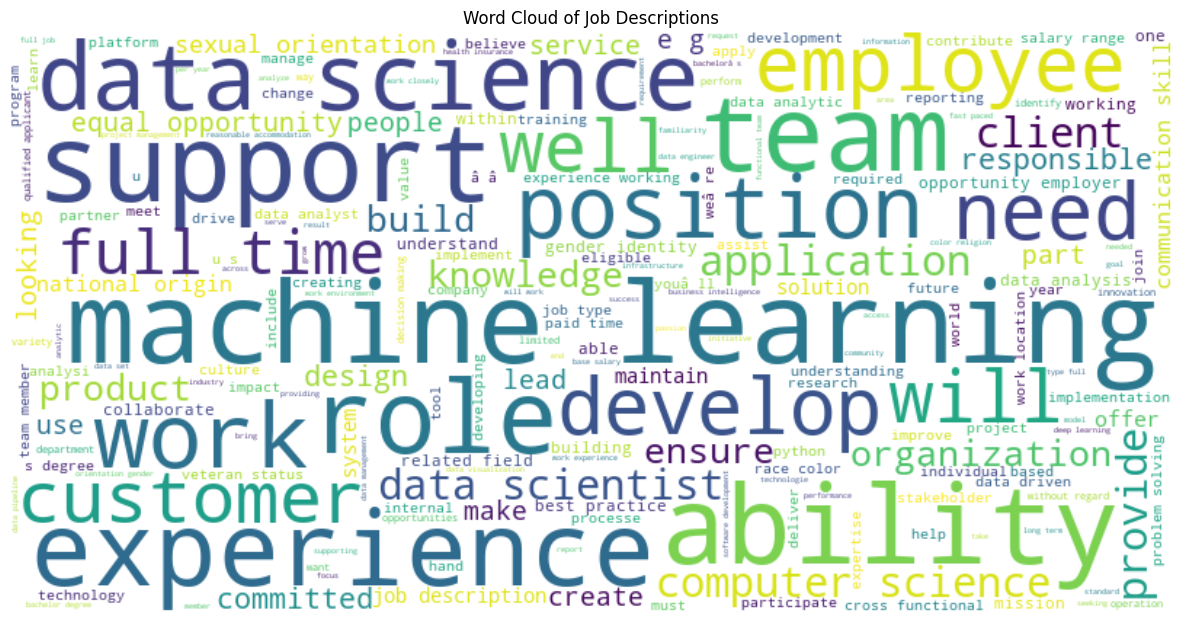

In [547]:
# Create a word cloud of the job descriptions
all_descriptions = ' '.join(df['Descriptions'].astype(str).str.lower())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Job Descriptions')
plt.show()

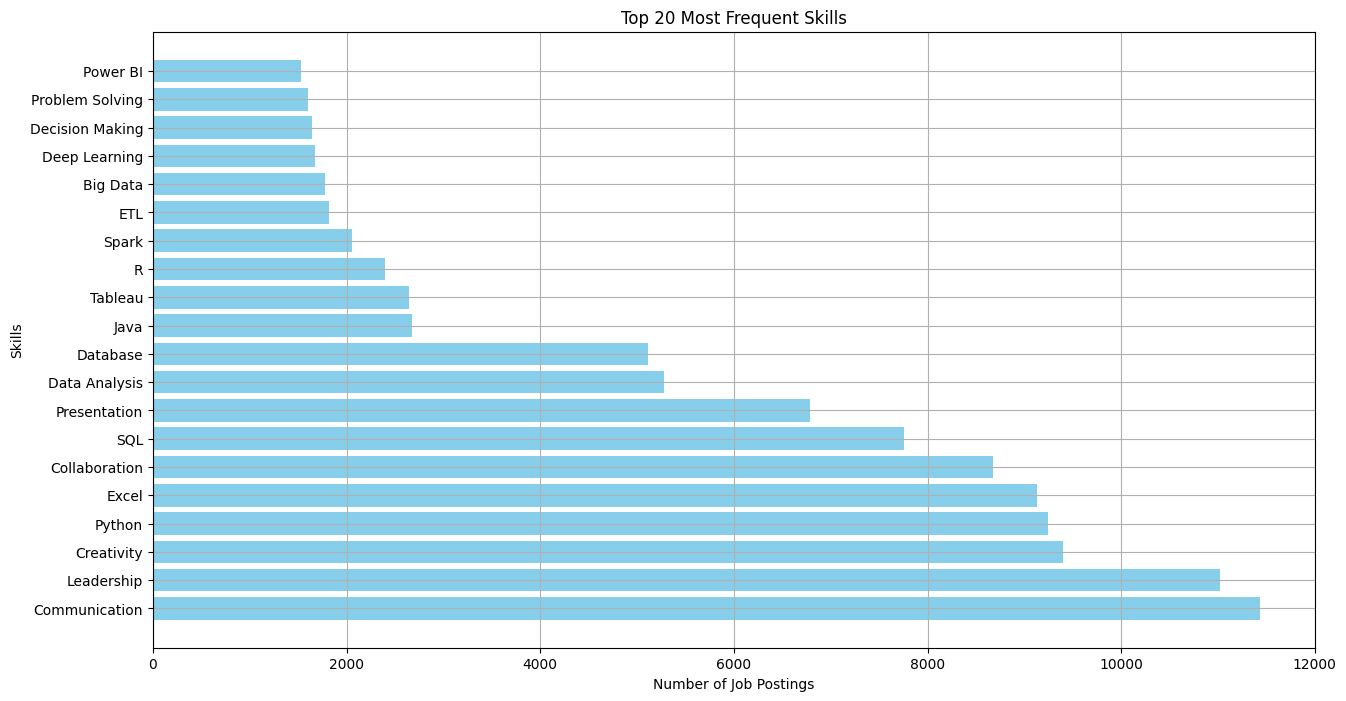

In [548]:
# Plot the top 20 most frequent skills
skill_counts = df_skills.sum(axis=0).sort_values(ascending=False).head(20)
plt.figure(figsize=(15, 8))
plt.barh(skill_counts.index, skill_counts.values, color='skyblue')
plt.xlabel('Number of Job Postings')
plt.ylabel('Skills')
plt.title('Top 20 Most Frequent Skills')
plt.grid()
plt.show()

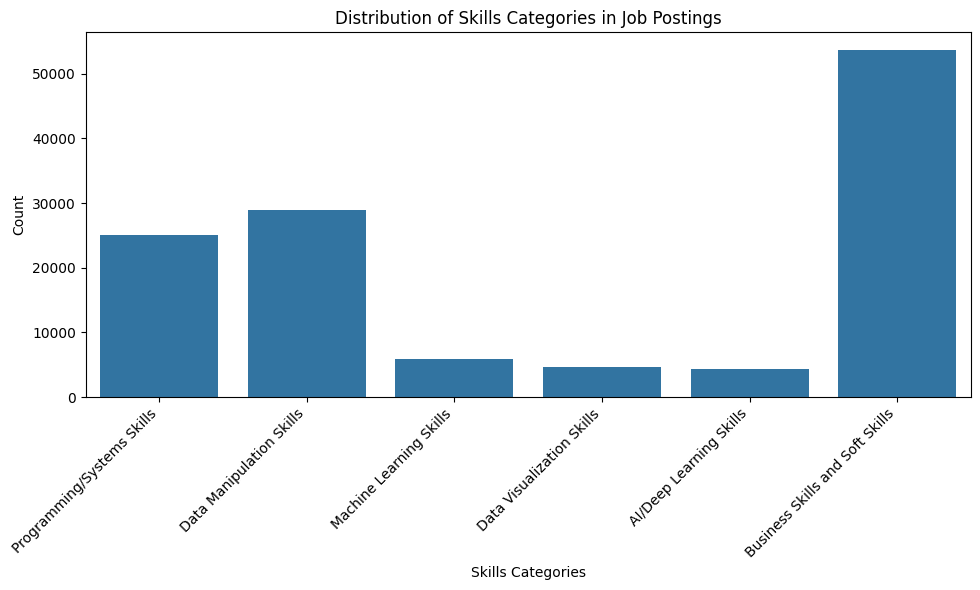

In [549]:
# Plot the distribution of each skill dictionary
# count the total number of 1s in each skill dictionary
sskills_count = df_skills[sskills.keys()].sum(axis=0).sum()
dmskills_count = df_skills[dmskills.keys()].sum(axis=0).sum()
mlskills_count = df_skills[mlskills.keys()].sum(axis=0).sum()
dvskills_count = df_skills[dvskills.keys()].sum(axis=0).sum()
aiskills_count = df_skills[aiskills.keys()].sum(axis=0).sum()
bskills_count = df_skills[bskills.keys()].sum(axis=0).sum()

# Create a dataframe with the counts
skills_counts = pd.DataFrame({
    'Skills': ['Programming/Systems Skills', 'Data Manipulation Skills', 'Machine Learning Skills',
               'Data Visualization Skills', 'AI/Deep Learning Skills', 'Business Skills and Soft Skills'],
    'Count': [sskills_count, dmskills_count, mlskills_count, dvskills_count, aiskills_count, bskills_count]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Skills', y='Count', data=skills_counts)
plt.title('Distribution of Skills Categories in Job Postings')
plt.xlabel('Skills Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Hierarchical Clustering Implementation

### Implement hierarchical clustering algorithm

In [550]:
# empty matrix
D = np.zeros([a.shape[1],a.shape[1]])

## Find all element-wise skill proximities (distances)
for k in range(a.shape[0]):
    for i in range(a.shape[1]):
        for j in range(a.shape[1]):
            # Hamming distance: count mismatches across job postings
            if a[k, i] != a[k, j]:
                D[i, j] += 1

# Normalize the distance matrix
D = D / a.shape[0]

In [551]:
## Creating Dendrogram for our data (Y is linkage matrix)
Y = sch.linkage(D, method='complete')

[]

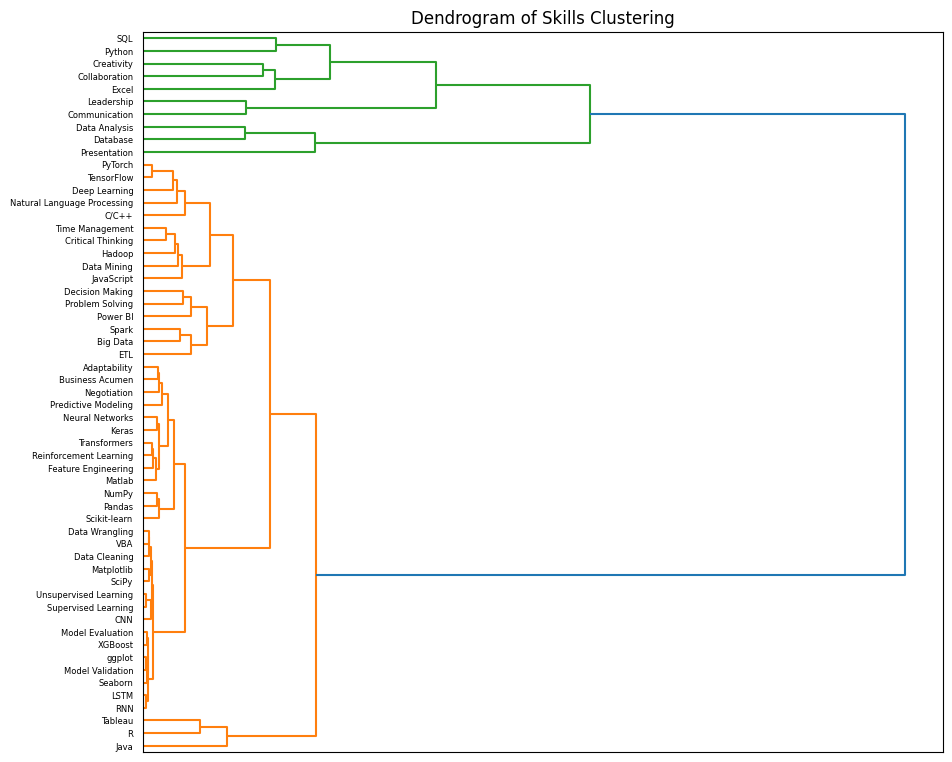

In [552]:
# Plot the Dendrogram
fig = plt.figure(figsize=(20,12))
ax = fig.add_axes([0.1,0.1,0.4,0.6])

Z = sch.dendrogram(Y, orientation='right')
plt.title('Dendrogram of Skills Clustering')
labels = df_skills.columns[Z['leaves']]
ax.set_xticks([])
ax.set_yticklabels(labels)
plt.savefig('dendrogram.png', format='png', bbox_inches='tight')
plt.plot()

[]

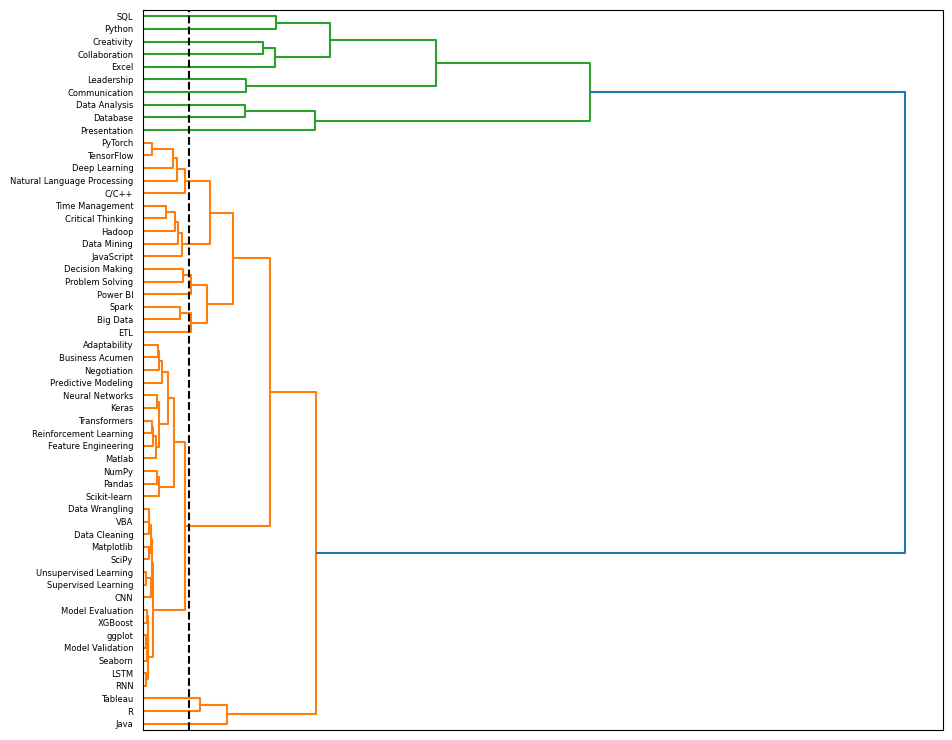

In [553]:
## Cutting the dendrogram at max_d
max_d = 0.38

fig = plt.figure(figsize=(20,12))
ax = fig.add_axes([0.1,0.1,0.4,0.6])

Z = sch.dendrogram(Y, orientation='right')
labels = df_skills.columns[Z['leaves']]
ax.set_xticks([])
ax.set_yticklabels(labels)

# Cutting the dendrogram at max_d
plt.axvline(x=max_d*D.max(), c='k', linestyle='--')

plt.plot()

In [554]:
## Identify clusters with max_d cut

lbs = sch.fcluster(Y, max_d*D.max(), 'distance')
clustr = lbs[Z['leaves']]

clust_skls = {}
for k in list(set(clustr)):
    clust_skls[k] = []

for j in range(len(labels)):
    clust_skls[clustr[j]].append(labels[j])

In [613]:
df_hierarchical = pd.DataFrame(index=df_skills.columns)
df_hierarchical['Cluster'] = clustr

In [614]:
df_hierarchical

,Cluster
Python,3
Matlab,1
C/C++,2
Java,4
JavaScript,4
R,4
SQL,4
VBA,4
Pandas,4
NumPy,4


In [555]:
for key, value in clust_skls.items():
    print(key, value)

1 ['R']
2 ['Tableau']
3 ['Java']
4 ['RNN', 'LSTM', 'Seaborn', 'Model Validation', 'ggplot', 'XGBoost', 'Model Evaluation', 'CNN', 'Supervised Learning', 'Unsupervised Learning', 'SciPy', 'Matplotlib', 'Data Cleaning', 'VBA', 'Data Wrangling', 'Scikit-learn', 'Pandas', 'NumPy', 'Matlab', 'Feature Engineering', 'Reinforcement Learning', 'Transformers', 'Keras', 'Neural Networks', 'Predictive Modeling', 'Negotiation', 'Business Acumen', 'Adaptability']
5 ['Big Data', 'Spark']
6 ['ETL']
7 ['Problem Solving', 'Decision Making']
8 ['Power BI']
9 ['JavaScript', 'Data Mining', 'Hadoop', 'Critical Thinking', 'Time Management']
10 ['C/C++', 'Natural Language Processing', 'Deep Learning', 'TensorFlow', 'PyTorch']
11 ['Database']
12 ['Data Analysis']
13 ['Presentation']
14 ['Communication']
15 ['Leadership']
16 ['Collaboration']
17 ['Creativity']
18 ['Excel']
19 ['Python']
20 ['SQL']


In [556]:
print("Number of automatically created clusters:",len(clust_skls))

Number of automatically created clusters: 20


#### Manually adjust clusters before analysis (if necessary)

In [557]:
clust_skills = {}
clust_skills[0] = ['Python', 'R', 'Java', 'C/C++', 'VBA', 'MATLAB', 'SQL']
clust_skills[1] = ['Pandas', 'NumPy', 'Data Wrangling', 'Data Cleaning', 'Data Analysis', 'Excel', 'Database']
clust_skills[2] = ['Supervised Learning', 'Unsupervised Learning', 'Scikit-learn',
            'XGBoost', 'Model Evaluation', 'Model Validation',
            'Predictive Modeling', 'Feature Engineering']
clust_skills[3] = ['Deep Learning', 'Neural Networks', 'TensorFlow', 'Keras', 'PyTorch', 'CNN', 'RNN', 'LSTM']
clust_skills[4] = ['GAN', 'Transformers', 'Reinforcement Learning', 'Natural Language Processing', 'SciPy', 'Data Mining']
clust_skills[5] = ['Tableau', 'Power BI', 'Matplotlib', 'Seaborn', 'ggplot', 'JavaScript']
clust_skills[6] = ['Big Data', 'Hadoop', 'Spark', 'ETL']
clust_skills[7] = ['Business Acumen', 'Negotiation', 'Decision Making', 'Problem Solving', 'Critical Thinking', 'Adaptability']
clust_skills[8] = ['Communication', 'Collaboration', 'Presentation', 'Leadership', 'Time Management', 'Creativity']

 Course 1-Programming for Data Science: ['Python', 'R', 'Java', 'C/C++', 'VBA', 'MATLAB', 'SQL']

 Course 2-Data Wrangling & Manipulation: ['Pandas', 'NumPy', 'Data Wrangling', 'Data Cleaning', 'Data Analysis', 'Excel', 'Database']

 Course 3-Machine Learning Foundations:['Supervised Learning', 'Unsupervised Learning', 'Scikit-learn', 'XGBoost', 'Model Evaluation', 'Model Validation', 'Predictive Modeling', 'Feature Engineering']

 Course 4-Deep Learning & AI: ['Deep Learning', 'Neural Networks', 'TensorFlow', 'Keras', 'PyTorch', 'CNN', 'RNN', 'LSTM']

 Course 5-Advanced Topics in AI & NLP: ['GAN', 'Transformers', 'Reinforcement Learning', 'Natural Language Processing', 'SciPy', 'Data Mining']

 Course 6-Data Visualization & BI Tools: ['Tableau', 'Power BI', 'Matplotlib', 'Seaborn', 'ggplot', 'JavaScript']

 Course 7-Big Data & Data Engineering: ['Big Data', 'Hadoop', 'Spark', 'ETL']

 Course 8-Business & Decision-Making Skills: ['Business Acumen', 'Negotiation', 'Decision Making', 'Problem Solving', 'Critical Thinking', 'Adaptability']

 Course 9-Communication, Collaboration & Leadership: ['Communication', 'Collaboration', 'Presentation', 'Leadership', 'Time Management', 'Creativity']

In [558]:
len(clust_skills)
print("Number of manually adjusted clusters:",len(clust_skills))

Number of manually adjusted clusters: 9


### Quantify the quality of clustering using silhouette scores

In [559]:
sil_score = silhouette_score(D, lbs, metric='precomputed')
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.216


To evaluate the quality of our hierarchical clustering results, we computed the silhouette score using the precomputed Hamming distance matrix and the cluster labels extracted from the dendrogram.

The resulting silhouette score was 0.216, indicating some structure, but also notable overlap among clusters. This is expected, given the complex and multi-disciplinary nature of real-world data science roles, where skills often appear together across contexts (e.g., Python in both data wrangling and machine learning).

## K-means Clustering Implementation

### Implement k-means clustering algorithm

#### Feature Engineering

In [560]:
skills = df_skills.columns.to_list()
df_kmeans = pd.DataFrame(index=skills)

# Feature 1: skill frequency
df_kmeans['Skill Frequency'] = df_skills.sum().astype(int)

In [561]:
# Feature 2: average salary
def extract_avg_salary(salary_str):
    if pd.isna(salary_str):
        return np.nan
    
    # Check if the salary_str is quoted as hourly or yearly
    is_hourly = 'hour' in salary_str.lower() or 'hourly' in salary_str.lower()

    # Extract all numbers from the string
    nums = re.findall(r'\$?([\d,]+)', salary_str)
    if len(nums) >= 2:
        low = int(nums[0].replace(',', ''))
        high = int(nums[1].replace(',', ''))
        avg = (low + high) / 2
    elif len(nums) == 1:
        avg = int(nums[0].replace(',', ''))
    else:
        return np.nan

    # Convert hourly to annual (assume 37.5 hr/week, 52 weeks)
    if is_hourly:
        avg = avg * 37.5 * 52

    return avg

In [562]:
df_salary = results['Salary'].copy()
df_salary = df_salary.apply(extract_avg_salary)
df_skills_salary = df_skills.copy()
df_skills_salary['Salary'] = df_salary

In [563]:
avg_salary_per_skill = {}

for skill in df_skills.columns:
    skill_mask = df_skills[skill] == 1
    avg_salary = df_skills_salary.loc[skill_mask, 'Salary'].mean()
    avg_salary_per_skill[skill] = avg_salary

avg_salary_series = pd.Series(avg_salary_per_skill, name='avg_salary')

In [564]:
df_kmeans['Avg Salary'] = avg_salary_series

In [565]:
# Feature 3: salary standard deviation
salary_std_per_skill = {}

for skill in df_skills.columns:
    skill_mask = df_skills[skill] == 1
    salary_std = df_skills_salary.loc[skill_mask, 'Salary'].std()
    salary_std_per_skill[skill] = salary_std

salary_std_series = pd.Series(salary_std_per_skill, name='salary_std')
df_kmeans['Salary Std'] = salary_std_series

In [566]:
# Feature 4: skill co-occurrence
avg_co_skills = {}

for skill in df_skills.columns:
    # Find postings that contain the current skill
    skill_postings = df_skills[df_skills[skill] == 1]
    
    # Count how many total skills (columns) are present per posting
    total_skills_in_postings = skill_postings.sum(axis=1)
    
    # Subtract 1 to exclude the current skill from the count
    avg_co = (total_skills_in_postings - 1).mean()
    
    avg_co_skills[skill] = avg_co

df_kmeans["Avg Co-occurence"] = pd.Series(avg_co_skills)


In [567]:
# Feature 5: Is Technical Skill?
for skill in df_skills.columns:
    if skill in sskills.keys() or skill in dmskills.keys() or skill in mlskills.keys() or skill in dvskills.keys() or skill in aiskills.keys():
        df_kmeans.loc[skill, 'Is Technical Skill'] = 1
    else:
        df_kmeans.loc[skill, 'Is Technical Skill'] = 0
df_kmeans['Is Technical Skill'] = df_kmeans['Is Technical Skill'].astype(int)

In [568]:
# Feature 6: proportion of job postings mentioning the skill that also have a "high-complexity" job title
high_complexity_keywords = [
    'senior', 'principal', 'lead', 'head', 'vp', 'chief',
    'strategic', 'executive', 'director', 'architect'
]

df['High Complexity'] = df['Title'].str.lower().fillna('')
is_high_complexity = df['High Complexity'].apply(
    lambda t: any(keyword in t for keyword in high_complexity_keywords)
)

In [569]:
high_complexity_score = {}

for skill in df_skills.columns:
    skill_mask = df_skills[skill] == 1

    total_postings = skill_mask.sum()
    if total_postings == 0:
        high_complexity_score[skill] = 0
    else:
        count_in_high = (skill_mask & is_high_complexity).sum()
        high_complexity_score[skill] = count_in_high / total_postings

In [570]:
df_kmeans['High Complexity Title %'] = pd.Series(high_complexity_score)

In [571]:
# Feature 7: Average word count in job descriptions mentioning the skill
df['desc_word_count'] = df['Descriptions'].str.split().str.len()
avg_word_count_per_skill = {}
for skill in df_skills.columns:
    skill_mask = df_skills[skill] == 1
    avg_word_count = df.loc[skill_mask, 'desc_word_count'].mean()
    avg_word_count_per_skill[skill] = avg_word_count

In [572]:
df_kmeans['Avg Description Length'] = pd.Series(avg_word_count_per_skill)

In [573]:
# Feature 8: How many different companies mention the skill
company_count_per_skill = {}

for skill in df_skills.columns:
    mask = df_skills[skill] == 1
    companies = df.loc[mask, 'Company'].dropna().unique()
    company_count_per_skill[skill] = len(companies)

In [574]:
df_kmeans['Company Count'] = pd.Series(company_count_per_skill)

In [576]:
# Feature 9: if the skill is a programming language
for skill in df_skills.columns:
    if skill in sskills.keys():
        df_kmeans.loc[skill, 'Programming Language'] = 1
    else:
        df_kmeans.loc[skill, 'Programming Language'] = 0
df_kmeans['Programming Language'] = df_kmeans['Programming Language'].astype(int)

In [577]:
# Feature 10: Count the number of times the skill is mentioned in job postings that are located in Toronto
toronto_mask = df['Location'].str.lower().str.contains('toronto', na=False)
df_skills_toronto = df_skills[toronto_mask]
skill_counts_toronto = df_skills_toronto.sum(axis=0).astype(int)
df_kmeans['Toronto Count'] = skill_counts_toronto

In [578]:
df_kmeans

,Skill Frequency,Avg Salary,Salary Std,Avg Co-occurence,Is Technical Skill,High Complexity Title %,Avg Description Length,Company Count,Programming Language,Toronto Count
Python,9248,133133.065555,55821.202284,7.715290,1,0.291739,670.552011,4766,1,486
Matlab,345,130187.828244,58744.572204,9.510145,1,0.263768,723.579710,321,1,18
C/C++,1447,140741.554726,54611.073493,8.186593,1,0.325501,711.775397,1136,1,103
Java,2674,136183.888630,53869.962053,8.170157,1,0.300673,665.933807,1933,1,117
JavaScript,1037,129609.015957,52456.676151,7.848602,1,0.290260,655.939248,853,1,47
R,2397,130598.578044,58547.028199,9.184397,1,0.282019,684.345849,1811,1,131
SQL,7758,127650.442715,55502.803413,7.758185,1,0.275458,659.338103,4770,1,450
VBA,184,111289.088235,58453.636389,8.130435,1,0.250000,668.869565,181,1,22
Pandas,752,133934.981544,56067.462924,11.194149,1,0.307181,678.715426,650,0,58
NumPy,543,137516.138743,58716.614002,11.493554,1,0.325967,687.889503,488,0,50


#### Implement K-Means Clustering

In [579]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans)

In [580]:
inertias = []
k_range = range(2, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

### Plot the elbow curve and implement the best k

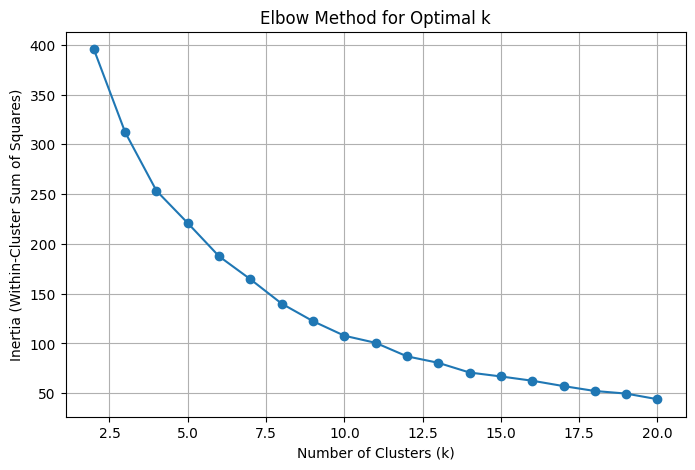

In [581]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [592]:
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_scaled)
df_kmeans['Cluster'] = kmeans.labels_

### Develop curriculum

In [599]:
# Reset index
skills_with_clusters = df_kmeans.reset_index()[['index', 'Cluster']].rename(columns={'index': 'Skill'})

# Group and print each cluster
kmeans_clusters = {}
for cluster_id in range(optimal_k):
    skills = skills_with_clusters[skills_with_clusters['Cluster'] == cluster_id]['Skill'].tolist()
    kmeans_clusters[cluster_id] = skills
    print(f"\nCourse {cluster_id + 1} (Cluster {cluster_id}):")
    print(skills)


Course 1 (Cluster 0):
['Business Acumen', 'Problem Solving', 'Critical Thinking', 'Time Management', 'Adaptability', 'Negotiation', 'Decision Making']

Course 2 (Cluster 1):
['Pandas', 'NumPy', 'SciPy', 'Big Data', 'Data Mining', 'Hadoop', 'Spark', 'ETL', 'Supervised Learning', 'Unsupervised Learning', 'Reinforcement Learning', 'Scikit-learn', 'TensorFlow', 'Keras', 'PyTorch', 'Predictive Modeling', 'Feature Engineering', 'Deep Learning', 'Neural Networks', 'Natural Language Processing', 'Transformers', 'CNN', 'RNN', 'LSTM']

Course 3 (Cluster 2):
['Matlab', 'C/C++', 'Java', 'JavaScript', 'R', 'VBA']

Course 4 (Cluster 3):
['Communication', 'Collaboration', 'Leadership', 'Creativity', 'Presentation']

Course 5 (Cluster 4):
['Data Wrangling', 'XGBoost', 'Matplotlib', 'Seaborn', 'ggplot']

Course 6 (Cluster 5):
['Database', 'Data Analysis', 'Tableau', 'Power BI']

Course 7 (Cluster 6):
['Python', 'SQL', 'Excel']

Course 8 (Cluster 7):
['Data Cleaning', 'Model Evaluation', 'Model Validat

In [600]:
# Rename clusters for better understanding
kmeans_courses = {'Basics for Data Science': kmeans_clusters[6],
                  'Basics for Data Analysis and visualization': kmeans_clusters[5],
                  'Advanced Programming Languages': kmeans_clusters[2],
                  'Data Manipulation, Machine Learning and AI': kmeans_clusters[1],
                  'Data Preparation & Visualization': kmeans_clusters[4],
                  'Model Evaluation and Validation': kmeans_clusters[7],
                  'Leadership, Communication & Collaboration': kmeans_clusters[3],
                  'Strategic Thinking & Business Acumen': kmeans_clusters[0]}


In [601]:
# Print the renamed clusters
for course, skills in kmeans_courses.items():
    print(f"\n{course}:")
    print(skills)


Basics for Data Science:
['Python', 'SQL', 'Excel']

Basics for Data Analysis and visualization:
['Database', 'Data Analysis', 'Tableau', 'Power BI']

Advanced Programming Languages:
['Matlab', 'C/C++', 'Java', 'JavaScript', 'R', 'VBA']

Data Manipulation, Machine Learning and AI:
['Pandas', 'NumPy', 'SciPy', 'Big Data', 'Data Mining', 'Hadoop', 'Spark', 'ETL', 'Supervised Learning', 'Unsupervised Learning', 'Reinforcement Learning', 'Scikit-learn', 'TensorFlow', 'Keras', 'PyTorch', 'Predictive Modeling', 'Feature Engineering', 'Deep Learning', 'Neural Networks', 'Natural Language Processing', 'Transformers', 'CNN', 'RNN', 'LSTM']

Data Preparation & Visualization:
['Data Wrangling', 'XGBoost', 'Matplotlib', 'Seaborn', 'ggplot']

Model Evaluation and Validation:
['Data Cleaning', 'Model Evaluation', 'Model Validation']

Leadership, Communication & Collaboration:
['Communication', 'Collaboration', 'Leadership', 'Creativity', 'Presentation']

Strategic Thinking & Business Acumen:
['Busi

### Scatterplot for K-Means Clustering

In [603]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

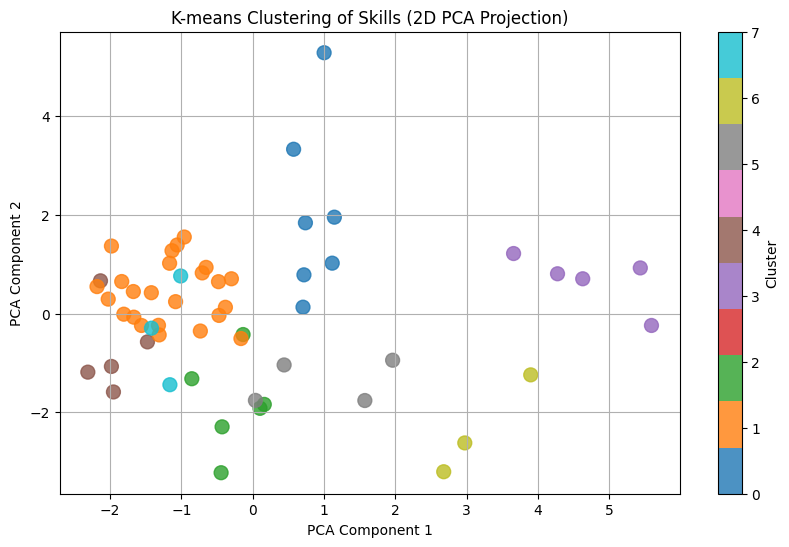

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_kmeans['Cluster'], cmap='tab10', s=100, alpha=0.8)
plt.title("K-means Clustering of Skills (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()

### Quantify the quality of k-means clustering

In [606]:
score = silhouette_score(X_scaled, df_kmeans['Cluster'])
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.358


Using the silhouette score as a clustering quality metric, the final K-means clustering (k=8) yielded a score of 0.358, indicating reasonably distinct and meaningful clusters. This suggests that the engineered features effectively capture the differences in skills, justifying the use of K-means for course design.

## Combine results from parts 2 and 3

In [615]:
ensemble_df = pd.DataFrame(index=df_kmeans.index)
ensemble_df['kmeans'] = df_kmeans['Cluster']
ensemble_df['hier'] = df_hierarchical['Cluster']

In [617]:
n = len(ensemble_df)
coassoc_matrix = np.zeros((n, n))
label_sources = ['kmeans', 'hier']


for label_type in label_sources:
    labels = ensemble_df[label_type].values
    for i in range(n):
        for j in range(n):
            if labels[i] == labels[j]:
                coassoc_matrix[i, j] += 1

# Normalize to turn into proportion
coassoc_matrix /= len(label_sources)

In [ ]:
# Convert similarity to dissimilarity
dissimilarity = 1 - coassoc_matrix
condensed_dist = squareform(dissimilarity, checks=False)

# Run linkage on dissimilarity
Z = linkage(condensed_dist, method='average')

# Choose number of clusters for ensemble result
ensemble_labels = fcluster(Z, t=8, criterion='maxclust')

In [621]:
ensemble_df['EnsembleCluster'] = ensemble_labels

In [623]:
for c in sorted(ensemble_df['EnsembleCluster'].unique()):
    skills = ensemble_df[ensemble_df['EnsembleCluster'] == c].index.tolist()
    print(f"\nEnsemble Cluster {c}:")
    print(skills)


Ensemble Cluster 1:
['Problem Solving', 'Critical Thinking', 'Time Management', 'Adaptability', 'Negotiation', 'Decision Making']

Ensemble Cluster 2:
['Collaboration', 'Leadership', 'Creativity', 'Presentation']

Ensemble Cluster 3:
['Model Evaluation', 'Model Validation']

Ensemble Cluster 4:
['Tableau', 'Power BI']

Ensemble Cluster 5:
['Matplotlib', 'Seaborn']

Ensemble Cluster 6:
['Python', 'Matlab', 'C/C++', 'Java', 'JavaScript', 'R', 'SQL', 'VBA', 'Pandas', 'NumPy', 'SciPy', 'Big Data', 'Data Mining', 'Data Wrangling', 'Data Cleaning', 'Database', 'Data Analysis', 'Hadoop', 'Spark', 'Excel', 'ETL', 'Supervised Learning', 'Unsupervised Learning', 'Reinforcement Learning', 'Scikit-learn', 'TensorFlow', 'Keras', 'PyTorch', 'XGBoost', 'Predictive Modeling', 'Feature Engineering']

Ensemble Cluster 7:
['ggplot', 'Deep Learning', 'Neural Networks', 'Natural Language Processing', 'Transformers']

Ensemble Cluster 8:
['CNN', 'RNN', 'LSTM', 'Business Acumen', 'Communication']


## Interpretation of results using LLM API

In [654]:
input_skills = ''
for i in kmeans_clusters.keys():
    input_skills += 'Course ' + str(i+1) + ': ' + ', '.join(kmeans_clusters[i]) + '; '
input_skills = input_skills[:-2]

In [655]:
print(input_skills)

Course 1: Business Acumen, Problem Solving, Critical Thinking, Time Management, Adaptability, Negotiation, Decision Making; Course 2: Pandas, NumPy, SciPy, Big Data, Data Mining, Hadoop, Spark, ETL, Supervised Learning, Unsupervised Learning, Reinforcement Learning, Scikit-learn, TensorFlow, Keras, PyTorch, Predictive Modeling, Feature Engineering, Deep Learning, Neural Networks, Natural Language Processing, Transformers, CNN, RNN, LSTM; Course 3: Matlab, C/C++, Java, JavaScript, R, VBA; Course 4: Communication, Collaboration, Leadership, Creativity, Presentation; Course 5: Data Wrangling, XGBoost, Matplotlib, Seaborn, ggplot; Course 6: Database, Data Analysis, Tableau, Power BI; Course 7: Python, SQL, Excel; Course 8: Data Cleaning, Model Evaluation, Model Validation


In [ ]:
prompt_1 = 'You are a university course designer. Given the following list of 8 data science-related courses with their associated skill sets, write a compelling paragraph that summarizes the overall program and entices students to enroll. Emphasize the career readiness, diversity of skills, and industry relevance: {input}'

In [657]:
prompt1 = prompt_1.format(input=input_skills)

In [658]:
prompt1

'You are a university course designer. Given the following list of 8 data science-related courses with their associated skill sets, write a compelling paragraph that summarizes the overall program and entices students to enroll. Emphasize the career readiness, diversity of skills, and industry relevance.e: Course 1: Business Acumen, Problem Solving, Critical Thinking, Time Management, Adaptability, Negotiation, Decision Making; Course 2: Pandas, NumPy, SciPy, Big Data, Data Mining, Hadoop, Spark, ETL, Supervised Learning, Unsupervised Learning, Reinforcement Learning, Scikit-learn, TensorFlow, Keras, PyTorch, Predictive Modeling, Feature Engineering, Deep Learning, Neural Networks, Natural Language Processing, Transformers, CNN, RNN, LSTM; Course 3: Matlab, C/C++, Java, JavaScript, R, VBA; Course 4: Communication, Collaboration, Leadership, Creativity, Presentation; Course 5: Data Wrangling, XGBoost, Matplotlib, Seaborn, ggplot; Course 6: Database, Data Analysis, Tableau, Power BI; Cou

In [652]:
response1 = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": prompt1},
    ],
    temperature=1.3,
    stream=False
)

print(response1.choices[0].message.content)

Unlock your future in the fast-growing field of data science with our comprehensive and industry-aligned program! Designed to transform you into a versatile, career-ready professional, this curriculum equips you with everything from foundational skills in Python, SQL, and Excel to advanced expertise in machine learning, AI, and big data technologies like Hadoop and Spark. Master cutting-edge tools such as TensorFlow, PyTorch, and Tableau while honing your ability to manipulate, visualize, and interpret data with precision. Beyond technical prowess, our program emphasizes essential leadership, communication, and strategic thinking skills—ensuring you can effectively present insights, collaborate across teams, and drive data-driven business decisions. Whether you're aspiring to become a data scientist, AI specialist, or analytics leader, this program prepares you to excel in diverse roles with hands-on experience in predictive modeling, NLP, deep learning, and more. Gain the competitive 

In [659]:
prompt_2 = 'You are a curriculum analyst. Given the following skill clusters, explain what types of roles or real-world applications each cluster aligns with. Identify common themes or shared competencies within each cluster to help justify why the skills belong together: {input}'

In [660]:
prompt2 = prompt_2.format(input=input_skills)

In [661]:
prompt2

'You are a curriculum analyst. Given the following skill clusters, explain what types of roles or real-world applications each cluster aligns with. Identify common themes or shared competencies within each cluster to help justify why the skills belong together: Course 1: Business Acumen, Problem Solving, Critical Thinking, Time Management, Adaptability, Negotiation, Decision Making; Course 2: Pandas, NumPy, SciPy, Big Data, Data Mining, Hadoop, Spark, ETL, Supervised Learning, Unsupervised Learning, Reinforcement Learning, Scikit-learn, TensorFlow, Keras, PyTorch, Predictive Modeling, Feature Engineering, Deep Learning, Neural Networks, Natural Language Processing, Transformers, CNN, RNN, LSTM; Course 3: Matlab, C/C++, Java, JavaScript, R, VBA; Course 4: Communication, Collaboration, Leadership, Creativity, Presentation; Course 5: Data Wrangling, XGBoost, Matplotlib, Seaborn, ggplot; Course 6: Database, Data Analysis, Tableau, Power BI; Course 7: Python, SQL, Excel; Course 8: Data Clea

In [662]:
response2 = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": prompt2},
    ],
    temperature=1.3,
    stream=False
)

print(response2.choices[0].message.content)

Here’s a breakdown of the skill clusters, their aligned roles/real-world applications, and the shared themes or competencies that justify their grouping:

---

### **Course 1: Business Acumen, Problem Solving, Critical Thinking, Time Management, Adaptability, Negotiation, Decision Making**  
**Roles/Applications:**  
- **Business Analysts, Consultants, Managers, Entrepreneurs** (roles requiring strategic thinking and operational efficiency).  
- **Project Management** (balancing resources, deadlines, and stakeholder needs).  
- **Sales/Marketing** (negotiation, adaptability, and decision-making for client interactions).  

**Shared Themes:**  
- **Core Business Skills:** Focus on high-level decision-making, efficiency, and interpersonal dynamics.  
- **Soft Skills for Leadership:** All skills are critical for leading teams, driving projects, and navigating ambiguity in business environments.  

---

### **Course 2: Pandas, NumPy, SciPy, Big Data, Data Mining, Hadoop, Spark, ETL, Superv